In [1]:
import pandas as pd
import ast
from pickle import load
import pickle

In [20]:
#pip install pyupset
#import pyupset as pyu
from upsetplot import generate_counts, plot
from matplotlib import pyplot as plt


# Abstract level CT annotation and evaluation

In [21]:
prompt_version_to_evaluate = "v1"
df_conditions = pd.read_csv(f"./evaluations/evaluated_ct_level_conditions_gpt_prompt_{prompt_version_to_evaluate}.csv")
df_drugs = pd.read_csv(f"./evaluations/evaluated_ct_level_drugs_gpt_prompt_{prompt_version_to_evaluate}.csv")


In [22]:
def check_match(row, column, target_col='canonical_unique_conditions'):
    cell = row[column]
    if pd.isna(cell):
        return False  # If cell is NaN, return False immediately
    conditions = set(str(cell).split('|'))
    return row[target_col] in conditions
    
   
def check_partial_match(row, column, target_col='canonical_unique_conditions'):
    target_words = row[target_col].lower().split()
    predictions = row[column]
    
    if pd.isna(predictions):
        return False
        
    predictions = predictions.lower().split('|')
    matching_count = 0

    for prediction_string in predictions:
        prediction_words = prediction_string.split()
        #print(target_words, prediction_words)
        common_words = set(target_words) & set(prediction_words)
        #print(common_words)
        # Check if more than half of the target words overlap
        if len(common_words) >= len(target_words) / 2:
            matching_count += 1

    return matching_count > 0 

## Conditions

In [47]:
df_conditions

,Unnamed: 0,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_bert-base-uncased_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt_conditions,canonical_gpt-4_conditions,eval_exact_match_bert-base-uncased,...,eval_majority_BioLinkBERT-base,eval_majority_BioLinkBERT-base_tp_fp_fn,eval_majority_biobert-v1.1,eval_majority_biobert-v1.1_tp_fp_fn,eval_majority_gpt,eval_majority_gpt_tp_fp_fn,eval_majority_gpt-4,eval_majority_gpt-4_tp_fp_fn,eval_majority_aact,eval_majority_aact_tp_fp_fn
0,0,NCT04849741,axd.|alexander disease,alexander disease,axd|alexander disease,axd|alexander disease,axd|alexander disease,alexander disease,alexander disease|gross motor function,"{'p': 0.5, 'r': 0.5, 'f1': 0.5}",...,"{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}"
1,1,NCT04576507,pain|chronic pain,cannabis|hyperalgesia|pain|tolerance,experimental pain|pain|chronic pain|abuse,pain|chronic pain|hyperalgesia,pain|chronic pain,chronic pain|pain|hyperalgesia|analgesic|abuse...,chronic pain|pain|hyperalgesia|analgesic effec...,"{'p': 0.5, 'r': 1.0, 'f1': 0.67}",...,"{'p': 0.67, 'r': 1.0, 'f1': 0.8}","{'tp': 2, 'fp': 1, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.29, 'r': 1.0, 'f1': 0.44}","{'tp': 2, 'fp': 5, 'fn': 0}","{'p': 0.5, 'r': 1.0, 'f1': 0.67}","{'tp': 2, 'fp': 2, 'fn': 0}","{'p': 0.4, 'r': 1.0, 'f1': 0.57}","{'tp': 2, 'fp': 3, 'fn': 0}"
2,2,NCT00261508,autistic disorder|pervasive developmental diso...,asperger syndrome|autistic disorder|dcild deve...,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...,"{'p': 0.67, 'r': 1.0, 'f1': 0.8}",...,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.67, 'r': 1.0, 'f1': 0.8}","{'tp': 2, 'fp': 1, 'fn': 0}","{'p': 0.2, 'r': 0.5, 'f1': 0.29}","{'tp': 1, 'fp': 4, 'fn': 1}"
3,3,NCT01495923,lumbosacral radicular pain|lumbosacral radicul...,radiculopathy|sciatica,pain,pain|lumbosacral radicular pain|lumbosacral ra...,pain|lumbosacral radicular pain|lumbosacral ra...,lumbosacral radiculopathy|radicular pain,lumbosacral radiculopathy|radicular pain,"{'p': 0.0, 'r': 0.0, 'f1': 0}",...,"{'p': 0.67, 'r': 1.0, 'f1': 0.8}","{'tp': 2, 'fp': 1, 'fn': 0}","{'p': 0.67, 'r': 1.0, 'f1': 0.8}","{'tp': 2, 'fp': 1, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}"
4,4,NCT03150563,NaN,"contracture of muscle, thigh|muscle rigidity|s...",NaN,NaN,NaN,NaN,NaN,"{'p': 0, 'r': 0, 'f1': 0}",...,"{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,NCT03755362,moderate cognitive impairment|dementia|asympto...,carotid stenosis|mild cognitive impairment|per...,moderate cognitive impairment|tobacco|dementia...,moderate cognitive impairment|dementia|asympto...,moderate cognitive impairment|dementia|asympto...,periodontitis|dementia|mild cognitive impairme...,periodontitis|dementia|asymptomatic carotid ar...,"{'p': 0.75, 'r': 1.0, 'f1': 0.86}",...,"{'p': 

In [48]:
df_conditions_to_eval = df_conditions[['nct_id','canonical_unique_conditions', 'canonical_aact_conditions', 'canonical_BioLinkBERT-base_conditions', 'canonical_biobert-v1.1_conditions','canonical_gpt-4_conditions']]
# Split the first column by '|'
df_conditions_to_eval['canonical_unique_conditions'] = df_conditions_to_eval['canonical_unique_conditions'].str.split('|')

# Explode the DataFrame based on the first column
df_exploded = df_conditions_to_eval.explode('canonical_unique_conditions')
df_exploded = df_exploded.dropna(subset=['canonical_unique_conditions'])

df_exploded

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_51182/1436948201.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conditions_to_eval['canonical_unique_conditions'] = df_conditions_to_eval['canonical_unique_conditions'].str.split('|')


,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt-4_conditions
0,NCT04849741,axd.,alexander disease,axd|alexander disease,axd|alexander disease,alexander disease|gross motor function
0,NCT04849741,alexander disease,alexander disease,axd|alexander disease,axd|alexander disease,alexander disease|gross motor function
1,NCT04576507,pain,cannabis|hyperalgesia|pain|tolerance,pain|chronic pain|hyperalgesia,pain|chronic pain,chronic pain|pain|hyperalgesia|analgesic effec...
1,NCT04576507,chronic pain,cannabis|hyperalgesia|pain|tolerance,pain|chronic pain|hyperalgesia,pain|chronic pain,chronic pain|pain|hyperalgesia|analgesic effec...
2,NCT00261508,autistic disorder,asperger syndrome|autistic disorder|dcild deve...,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...
...,...,...,...,...,...,...
86,NCT00506415,mild to moderate alzheimer's disease,alzheimer disease,alzheimer disease|mild to moderate alzheimer's...,alzheimer disease|mild to moderate alzheimer's...,alzheimer disease|functional decline|cognitive...
86,NCT00506415,functional and cognitive decline,alzheimer disease,alzheimer disease|mild to moderate alzheimer's...,alzheimer disease|mild to moderate alzheimer's...,alzheimer disease|functional decline|cognitive...
87,NCT01344447,vascular disease of the supra-aortic vessels,carotid stenosis,vascular disease of the supra-aortic vessels,known or suspected vascular disease of the su|...,vascular disease of the supra-aortic vessels
88,NCT04184206,depression,"attention training|depression|symptoms, affect...",depression|major depressive disorder,depression|major depressive disorder,major depressive disorder|symptoms


In [49]:
# Apply the function to create new columns
df_exploded['is_in_AACT_partial'] = df_exploded.apply(check_partial_match, column='canonical_aact_conditions', axis=1)
df_exploded['is_in_BioLinkBERT_partial'] = df_exploded.apply(check_partial_match, column='canonical_BioLinkBERT-base_conditions', axis=1)
df_exploded['is_in_BioBERT_partial'] = df_exploded.apply(check_partial_match, column='canonical_biobert-v1.1_conditions', axis=1)
df_exploded['is_in_gpt-4_partial'] = df_exploded.apply(check_partial_match, column='canonical_gpt-4_conditions', axis=1)

# Apply the function to create new columns
df_exploded['is_in_AACT'] = df_exploded.apply(check_match, column='canonical_aact_conditions', axis=1)
df_exploded['is_in_BioLinkBERT'] = df_exploded.apply(check_match, column='canonical_BioLinkBERT-base_conditions', axis=1)
df_exploded['is_in_BioLinkBERT'] = df_exploded.apply(check_match, column='canonical_BioLinkBERT-base_conditions', axis=1)
df_exploded['is_in_BioBERT'] = df_exploded.apply(check_match, column='canonical_biobert-v1.1_conditions', axis=1)
df_exploded['is_in_gpt-4'] = df_exploded.apply(check_match, column='canonical_gpt-4_conditions', axis=1)

df_exploded

,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt-4_conditions,is_in_AACT_partial,is_in_BioLinkBERT_partial,is_in_BioBERT_partial,is_in_gpt-4_partial,is_in_AACT,is_in_BioLinkBERT,is_in_BioBERT,is_in_gpt-4
0,NCT04849741,axd.,alexander disease,axd|alexander disease,axd|alexander disease,alexander disease|gross motor function,False,False,False,False,False,False,False,False
0,NCT04849741,alexander disease,alexander disease,axd|alexander disease,axd|alexander disease,alexander disease|gross motor function,True,True,True,True,True,True,True,True
1,NCT04576507,pain,cannabis|hyperalgesia|pain|tolerance,pain|chronic pain|hyperalgesia,pain|chronic pain,chronic pain|pain|hyperalgesia|analgesic effec...,True,True,True,True,True,True,True,True
1,NCT04576507,chronic pain,cannabis|hyperalgesia|pain|tolerance,pain|chronic pain|hyperalgesia,pain|chronic pain,chronic pain|pain|hyperalgesia|analgesic effec...,True,True,True,True,False,True,True,True
2,NCT00261508,autistic disorder,asperger syndrome|autistic disorder|dcild deve...,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,NCT00506415,mild to moderate alzheimer's disease,alzheimer disease,alzheimer disease|mild to moderate alzheimer's...,alzheimer disease|mild to moderate alzheimer's...,alzheimer disease|functional decline|cognitive...,False,True,True,False,False,True,True,False
86,NCT00506415,functional and cognitive decline,alzheimer disease,alzheimer disease|mild to moderate alzheimer's...,alzheimer disease|mild to moderate alzheimer's...,alzheimer disease|functional decline|cognitive...,False,True,True,True,False,True,True,False
87,NCT01344447,vascular disease of the supra-aortic vessels,carotid stenosis,vascular disease of the supra-aortic vessels,known or suspected vascular disease of the su|...,vascular disease of the supra-aortic vessels,False,True,True,True,False,True,False,True
88,NCT04184206,depression,"attention training|depression|symptoms, affect...",depression|major depressive disorder,depression|major depressive disorder,major depressive disorder|symptoms,True,True,True,False,True,True,True,False


In [50]:
df_exploded.to_csv("./evaluations/upset_plot_check_conditions.csv")

In [51]:
df_exploded[df_exploded['nct_id']=="NCT01344447"]

,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt-4_conditions,is_in_AACT_partial,is_in_BioLinkBERT_partial,is_in_BioBERT_partial,is_in_gpt-4_partial,is_in_AACT,is_in_BioLinkBERT,is_in_BioBERT,is_in_gpt-4
87,NCT01344447,vascular disease of the supra-aortic vessels,carotid stenosis,vascular disease of the supra-aortic vessels,known or suspected vascular disease of the su|...,vascular disease of the supra-aortic vessels,False,True,True,True,False,True,False,True


### Plot

In [52]:
set_names = ['is_in_AACT_partial', 'is_in_BioLinkBERT_partial', 'is_in_BioBERT_partial', 'is_in_gpt-4_partial']
#set_names = ['is_in_AACT', 'is_in_BioLinkBERT', 'is_in_BioBERT', 'is_in_gpt-4']

df = df_exploded[set_names]
df_up = df.groupby(set_names).size()
df_up

is_in_AACT_partial  is_in_BioLinkBERT_partial  is_in_BioBERT_partial  is_in_gpt-4_partial
False               False                      False                  False                   11
                                                                      True                    11
                    True                       False                  False                    6
                                                                      True                     2
                                               True                   False                   34
                                                                      True                    59
True                False                      False                  False                    2
                                               True                   True                     1
                    True                       False                  True                     4
                                     

In [53]:
#set_names.remove('is_in_gpt-4_partial')
set_names

['is_in_AACT_partial',
 'is_in_BioLinkBERT_partial',
 'is_in_BioBERT_partial',
 'is_in_gpt-4_partial']

In [54]:
# List of column names to check, excluding 'is_in_gpt-4'
model_to_review = 'is_in_BioLinkBERT_partial'
set_names_review = set_names.copy()
set_names_review.remove(model_to_review)

# Filter DataFrame
filtered_df = df_exploded[(df_exploded[set_names_review] == True).all(axis=1) & (df_exploded[model_to_review] == False)]
print(len(filtered_df))
filtered_df

1


,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt-4_conditions,is_in_AACT_partial,is_in_BioLinkBERT_partial,is_in_BioBERT_partial,is_in_gpt-4_partial,is_in_AACT,is_in_BioLinkBERT,is_in_BioBERT,is_in_gpt-4
19,NCT05375240,brain injuries,beta blocker|brain diseases|cardiovascular dis...,stroke|stroke-associated pneumonia|stroke-asso...,stroke|stroke-associated pneumonia|stroke-asso...,stroke associated pneumonia|stroke|urinary tra...,True,False,True,True,False,False,False,False


In [60]:
# List of column names to check, excluding 'is_in_gpt-4'
model_to_review = 'is_in_gpt-4_partial'
set_names_review = set_names.copy()
set_names_review.remove(model_to_review)

# Filter DataFrame
filtered_df = df_exploded[(df_exploded[set_names_review] == False).all(axis=1) & (df_exploded[model_to_review] == True)]
print(len(filtered_df))
filtered_df.to_csv("evaluations/upset_plot_unique_conditions_for_gpt4.csv")
filtered_df

11


,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt-4_conditions,is_in_AACT_partial,is_in_BioLinkBERT_partial,is_in_BioBERT_partial,is_in_gpt-4_partial,is_in_AACT,is_in_BioLinkBERT,is_in_BioBERT,is_in_gpt-4
19,NCT05375240,immunosuppression,beta blocker|brain diseases|cardiovascular dis...,stroke|stroke-associated pneumonia|stroke-asso...,stroke|stroke-associated pneumonia|stroke-asso...,stroke associated pneumonia|stroke|urinary tra...,False,False,False,True,False,False,False,False
20,NCT03546517,muscle stiffness,spasticity|stroke,stroke|cerebral vascular accident|chronic cere...,stroke|stiff|cerebral vascular accident|chroni...,chronic stroke|spasticity|muscle stiffness|imp...,False,False,False,True,False,False,False,True
29,NCT01118637,depression,trichotillomania,trichotillomania,loss|hair-pulling|pulling|trichotillomania,trichotillomania|repetitive pulling out of one...,False,False,False,True,False,False,False,True
29,NCT01118637,anxiety,trichotillomania,trichotillomania,loss|hair-pulling|pulling|trichotillomania,trichotillomania|repetitive pulling out of one...,False,False,False,True,False,False,False,True
31,NCT03177967,insomnia,sleep initiation and maintenance disorders,NaN,NaN,insomnia,False,False,False,True,False,False,False,True
33,NCT03562351,emergent seizure,status epilepticus,seizures,seizures|emerge,seizures|emergent seizure care,False,False,False,True,False,False,False,False
55,NCT02571335,impaired functional capacity,multiple sclerosis,chronic progressive or relapsing-remitting dis...,chronic progressive or relapsing-remitting dis...,multiple sclerosis|impaired functional capacit...,False,False,False,True,False,False,False,True
55,NCT02571335,reduced physical activity,multiple sclerosis,chronic progressive or relapsing-remitting dis...,chronic progressive or relapsing-remitting dis...,multiple sclerosis|impaired functional capacit...,False,False,False,True,False,False,False,True
55,NCT02571335,cognitive decline,multiple sclerosis,chronic progressive or relapsing-remitting dis...,chronic progressive or relapsing-remitting dis...,multiple sclerosis|impaired functional capacit...,False,False,False,True,False,False,False,True
63,NCT05696665,oxidative stress,neurodegenerative diseases|parkinson disease,parkinson disease|parkinson disease|pd|'s disease,parkinson disease|parkinson disease,parkinson disease|mds-unified parkinson's dise...,False,False,False,True,False,False,False,True


In [56]:
sum(df_up)

246

/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

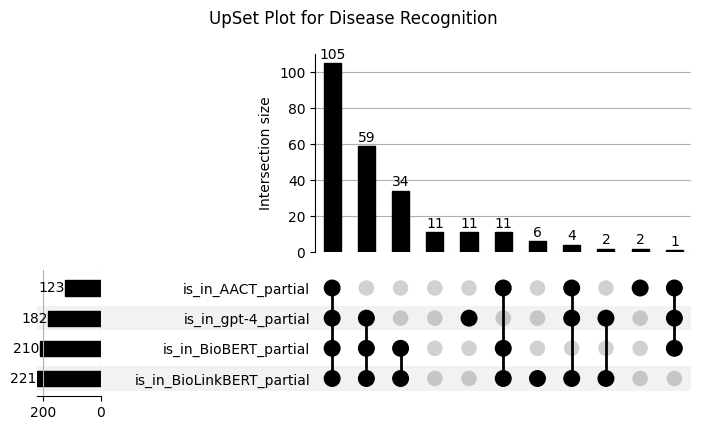

In [57]:
# NOTE: does not show false positives
plot(df_up, orientation='horizontal', show_counts=True, sort_by='cardinality') #, 'degree'}
plt.suptitle("UpSet Plot for Disease Recognition")
plt.tight_layout()
plt.savefig("./evaluations/plots/upset_plot_partial_match_condition.png")


## Drugs

In [36]:
df_drugs

,Unnamed: 0,nct_id,canonical_unique_interventions,canonical_bert-base-uncased_interventions,canonical_BioLinkBERT-base_interventions,canonical_biobert-v1.1_interventions,canonical_gpt_interventions,canonical_gpt-4_interventions,canonical_aact_interventions,eval_exact_match_bert-base-uncased,...,eval_majority_BioLinkBERT-base,eval_majority_BioLinkBERT-base_tp_fp_fn,eval_majority_biobert-v1.1,eval_majority_biobert-v1.1_tp_fp_fn,eval_majority_gpt,eval_majority_gpt_tp_fp_fn,eval_majority_gpt-4,eval_majority_gpt-4_tp_fp_fn,eval_majority_aact,eval_majority_aact_tp_fp_fn
0,0,NCT04849741,ion373,ion373,ion373,ion373,ion373,ion373,ion373,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}",...,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}"
1,1,NCT04576507,dronabinol|cannabinoids|dronabinol|cannabidiol...,cannabidiol|cannabinoids|dronabinol,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|opioids|cannabinoids|dronabin...,medical cannabis|delta-9-tetrahydrocannabinol ...,medical cannabis,"{'p': 1.0, 'r': 0.75, 'f1': 0.86}",...,"{'p': 0.67, 'r': 0.5, 'f1': 0.57}","{'tp': 2, 'fp': 1, 'fn': 2}","{'p': 0.33, 'r': 0.25, 'f1': 0.29}","{'tp': 1, 'fp': 2, 'fn': 3}","{'p': 0.6, 'r': 0.75, 'f1': 0.67}","{'tp': 3, 'fp': 2, 'fn': 1}","{'p': 0.33, 'r': 0.25, 'f1': 0.29}","{'tp': 1, 'fp': 2, 'fn': 3}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 4}"
2,2,NCT00261508,antipsychotic medication|risperidone,risperidon|anti|risperidone,antipsychotic medication|risperidone,antipsy,risperidone|placebo,risperidone,risperidone,"{'p': 0.33, 'r': 0.5, 'f1': 0.4}",...,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 2}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}"
3,3,NCT01495923,gabapentin|steroid,epid|gabapentin|steroid,gabapentin,gabapentin,epidural steroid injections|gabapentin,epidural steroid injections|gabapentin,gabapentin|gabapentin|sham epidural steroid in...,"{'p': 0.67, 'r': 1.0, 'f1': 0.8}",...,"{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}"
4,4,NCT03150563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'p': 0, 'r': 0, 'f1': 0}",...,"{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,NCT03755362,NaN,NaN,NaN,NaN,periodontitis,NaN,NaN,"{'p': 0, 'r': 0, 'f1': 0}",...,"{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}"
86,86,NCT00506415,rivastigmine|rivastigmine patch|rivastigmine,rivastigmine|rivastigmine patch|rivastigmine,rivastigmine|rivastigmine patch|rivastigmine,exelo|rivastigmine,rivastigmine patch|rivastigmine|rivastigmine p...,exelon®|rivastigmine patch,to 10 cm^2 patch|to 15 cm^2 patch|rivastigmine...,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}",...,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.5, 'r': 0.5

In [37]:
df_to_eval = df_drugs[['nct_id','canonical_unique_interventions', 'canonical_aact_interventions', 'canonical_BioLinkBERT-base_interventions', 'canonical_biobert-v1.1_interventions','canonical_gpt-4_interventions']]

# Split the first column by '|'
df_to_eval['canonical_unique_interventions'] = df_to_eval['canonical_unique_interventions'].str.split('|')

# Explode the DataFrame based on the first column
df_exploded = df_to_eval.explode('canonical_unique_interventions')
df_exploded = df_exploded.dropna(subset=['canonical_unique_interventions'])

df_exploded

/var/folders/nd/2fzvhsh510gbt9x6z5pdb1gr0000gn/T/ipykernel_51182/118845940.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_eval['canonical_unique_interventions'] = df_to_eval['canonical_unique_interventions'].str.split('|')


,nct_id,canonical_unique_interventions,canonical_aact_interventions,canonical_BioLinkBERT-base_interventions,canonical_biobert-v1.1_interventions,canonical_gpt-4_interventions
0,NCT04849741,ion373,ion373,ion373,ion373,ion373
1,NCT04576507,dronabinol,medical cannabis,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|delta-9-tetrahydrocannabinol ...
1,NCT04576507,cannabinoids,medical cannabis,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|delta-9-tetrahydrocannabinol ...
1,NCT04576507,dronabinol,medical cannabis,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|delta-9-tetrahydrocannabinol ...
1,NCT04576507,cannabidiol,medical cannabis,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|delta-9-tetrahydrocannabinol ...
...,...,...,...,...,...,...
84,NCT00120588,magnesium sulfate,magnesium,magnesium|magnesium sulfate,magnesium|magnesium sulfate,magnesium sulfate
86,NCT00506415,rivastigmine,to 10 cm^2 patch|to 15 cm^2 patch|rivastigmine...,rivastigmine|rivastigmine patch|rivastigmine,exelo|rivastigmine,exelon®|rivastigmine patch
86,NCT00506415,rivastigmine patch,to 10 cm^2 patch|to 15 cm^2 patch|rivastigmine...,rivastigmine|rivastigmine patch|rivastigmine,exelo|rivastigmine,exelon®|rivastigmine patch
86,NCT00506415,rivastigmine,to 10 cm^2 patch|to 15 cm^2 patch|rivastigmine...,rivastigmine|rivastigmine patch|rivastigmine,exelo|rivastigmine,exelon®|rivastigmine patch


In [38]:
df_exploded['is_in_AACT_partial'] = df_exploded.apply(check_partial_match, column='canonical_aact_interventions', target_col='canonical_unique_interventions', axis=1)
df_exploded['is_in_BioLinkBERT_partial'] = df_exploded.apply(check_partial_match, column='canonical_BioLinkBERT-base_interventions',target_col='canonical_unique_interventions', axis=1)
df_exploded['is_in_BioBERT_partial'] = df_exploded.apply(check_partial_match, column='canonical_biobert-v1.1_interventions',target_col='canonical_unique_interventions', axis=1)
df_exploded['is_in_gpt-4_partial'] = df_exploded.apply(check_partial_match, column='canonical_gpt-4_interventions',target_col='canonical_unique_interventions', axis=1)

# Apply the function to create new columns
df_exploded['is_in_AACT'] = df_exploded.apply(check_match, column='canonical_aact_interventions',target_col='canonical_unique_interventions', axis=1)
df_exploded['is_in_BioLinkBERT'] = df_exploded.apply(check_match, column='canonical_BioLinkBERT-base_interventions',target_col='canonical_unique_interventions', axis=1)
df_exploded['is_in_BioLinkBERT'] = df_exploded.apply(check_match, column='canonical_BioLinkBERT-base_interventions',target_col='canonical_unique_interventions', axis=1)
df_exploded['is_in_BioBERT'] = df_exploded.apply(check_match, column='canonical_biobert-v1.1_interventions',target_col='canonical_unique_interventions', axis=1)
df_exploded['is_in_gpt-4'] = df_exploded.apply(check_match, column='canonical_gpt-4_interventions',target_col='canonical_unique_interventions', axis=1)

df_exploded

,nct_id,canonical_unique_interventions,canonical_aact_interventions,canonical_BioLinkBERT-base_interventions,canonical_biobert-v1.1_interventions,canonical_gpt-4_interventions,is_in_AACT_partial,is_in_BioLinkBERT_partial,is_in_BioBERT_partial,is_in_gpt-4_partial,is_in_AACT,is_in_BioLinkBERT,is_in_BioBERT,is_in_gpt-4
0,NCT04849741,ion373,ion373,ion373,ion373,ion373,True,True,True,True,True,True,True,True
1,NCT04576507,dronabinol,medical cannabis,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|delta-9-tetrahydrocannabinol ...,False,False,False,False,False,False,False,False
1,NCT04576507,cannabinoids,medical cannabis,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|delta-9-tetrahydrocannabinol ...,False,True,False,False,False,True,False,False
1,NCT04576507,dronabinol,medical cannabis,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|delta-9-tetrahydrocannabinol ...,False,False,False,False,False,False,False,False
1,NCT04576507,cannabidiol,medical cannabis,cannabidi|cannabinoids|cannabidiol,cannabidiol|cannabino|canna,medical cannabis|delta-9-tetrahydrocannabinol ...,False,True,True,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,NCT00120588,magnesium sulfate,magnesium,magnesium|magnesium sulfate,magnesium|magnesium sulfate,magnesium sulfate,True,True,True,True,False,True,True,True
86,NCT00506415,rivastigmine,to 10 cm^2 patch|to 15 cm^2 patch|rivastigmine...,rivastigmine|rivastigmine patch|rivastigmine,exelo|rivastigmine,exelon®|rivastigmine patch,True,True,True,True,False,True,True,False
86,NCT00506415,rivastigmine patch,to 10 cm^2 patch|to 15 cm^2 patch|rivastigmine...,rivastigmine|rivastigmine patch|rivastigmine,exelo|rivastigmine,exelon®|rivastigmine patch,True,True,True,True,False,True,False,True
86,NCT00506415,rivastigmine,to 10 cm^2 patch|to 15 cm^2 patch|rivastigmine...,rivastigmine|rivastigmine patch|rivastigmine,exelo|rivastigmine,exelon®|rivastigmine patch,True,True,True,True,False,True,True,False


In [39]:
df_exploded.to_csv("./evaluations/upset_plot_check_drugs.csv")

### Plot

In [40]:
set_names = ['is_in_AACT_partial', 'is_in_BioLinkBERT_partial', 'is_in_BioBERT_partial', 'is_in_gpt-4_partial']
#set_names = ['is_in_AACT', 'is_in_BioLinkBERT', 'is_in_BioBERT', 'is_in_gpt-4']

df = df_exploded[set_names]
df_up = df.groupby(set_names).size()
df_up

is_in_AACT_partial  is_in_BioLinkBERT_partial  is_in_BioBERT_partial  is_in_gpt-4_partial
False               False                      False                  False                   6
                                                                      True                    1
                                               True                   False                   1
                                                                      True                    1
                    True                       False                  False                   3
                                                                      True                    1
                                               True                   False                   5
                                                                      True                    8
True                False                      False                  True                    1
                    True                      

/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/opt/anaconda3/envs/neurotrialner-notebooks/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

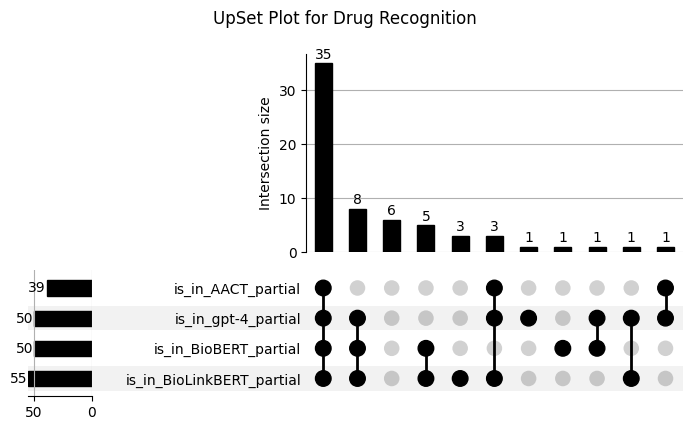

In [46]:
plot(df_up, orientation='horizontal', show_counts=True, sort_by='cardinality') #, 'degree'}
plt.suptitle("UpSet Plot for Drug Recognition")
plt.tight_layout()
plt.savefig("./evaluations/plots/upset_plot_partial_match_drug.png")

In [42]:
set_names

['is_in_AACT_partial',
 'is_in_BioLinkBERT_partial',
 'is_in_BioBERT_partial',
 'is_in_gpt-4_partial']

In [43]:
# List of column names to check, excluding 'is_in_gpt-4'
model_to_review = 'is_in_gpt-4_partial'
set_names_review = set_names.copy()
set_names_review.remove(model_to_review)

# Filter DataFrame
filtered_df = df_exploded[(df_exploded[set_names_review] == False).all(axis=1) & (df_exploded[model_to_review] == True)]
print(len(filtered_df))
filtered_df

1


,nct_id,canonical_unique_interventions,canonical_aact_interventions,canonical_BioLinkBERT-base_interventions,canonical_biobert-v1.1_interventions,canonical_gpt-4_interventions,is_in_AACT_partial,is_in_BioLinkBERT_partial,is_in_BioBERT_partial,is_in_gpt-4_partial,is_in_AACT,is_in_BioLinkBERT,is_in_BioBERT,is_in_gpt-4
89,NCT03540602,polyphenol,NaN,NaN,NaN,polyphenol rich supplementation,False,False,False,True,False,False,False,False


In [44]:
target_words = ["polyphenol"]
prediction_words = "polyphenol rich supplementation".split()
print(target_words, prediction_words)
#print(target_words, prediction_words)
common_words = set(target_words) & set(prediction_words)
#print(common_words)
# Check if more than half of the target words overlap
if len(common_words) >= len(target_words) / 2:
    print("matching")

['polyphenol'] ['polyphenol', 'rich', 'supplementation']
matching


In [45]:
from sklearn.metrics.pairwise import pairwise_distances
X = [[0, 0, 0], [1, 1, 1]]
Y = [[1, 0, 0], [1, 1, 0],[1, 0, 0],[1, 1, 1]]
pairwise_distances(X, Y, metric='sqeuclidean')


array([[1., 2., 1., 3.],
       [2., 1., 2., 0.]])

In [179]:
dist_matrix = pairwise_distances(X, Y, metric='sqeuclidean')
values, indices = torch.topk(-torch.from_numpy(dist_matrix), k=2, dim=-1)

In [180]:
import torch

In [188]:
values, indices = torch.topk(-torch.from_numpy(dist_matrix), k=2, dim=-1)

In [189]:
values

tensor([[-1., -1.],
        [-0., -1.]], dtype=torch.float64)

In [190]:
indices

tensor([[0, 2],
        [3, 1]])

In [184]:
Y

[[1, 0, 0], [1, 1, 0], [1, 0, 0], [1, 1, 1]]

In [191]:
from sklearn.metrics import cohen_kappa_score, confusion_matrix
y1 = ["negative", "positive", "negative", "neutral", "positive"]
y2 = ["negative", "positive", "negative", "neutral", "negative"]
cohen_kappa_score(y1, y2)

0.6875

In [192]:
confusion = confusion_matrix(y1, y2)


In [193]:
y1 = ["negative", "positive", "negative", "neutral", "positive", "negative", "positive", "negative", "neutral", "positive"]
y2 = ["negative", "positive", "negative", "neutral", "negative", "negative", "positive", "negative", "neutral", "positive"]
cohen_kappa_score(y1, y2)

0.84375